## Using CCD algorithem for solving Inverse kinematics
- Used the cyclic coordinate descent for solving the inverse kineamtics for a 5 DOF arm 
- It generate the trajectory according to the minimum jerk trajectory like the previous version (8), this version is 9
- The point is choosen randomly in space we can change them to choose specific points
- Readded forward kinematics to the get the positions of the joints and the end effector 
- Every thing else stayed nearly the same with minor adjustments

## Next steps
- [] Try to move from Kinematics to dynamics, to account for forces, masses, energy and inertia
- [v] Adding another trajectory generation type
- [v] Try to find a way to optimize the CCD algo 
- [v] Add the analysis plots
- [] set a set of a reaching movement 
- [] fix the jump in angles
- [] send the jonits angled after they are fixed



## Library Imports

In [49]:
import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.spatial.transform import Rotation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

## This is a simplified Dynamics for the model 
need to optimize it and refine the code

In [50]:
class ArmDynamics:
    """Dynamics simulation for the 3D arm model."""

    def __init__(self):
        # Mass properties of the arm segments
        self.mass_upper_arm = 2.0 # kg
        self.mass_forearm = 1.5  # kg
        self.mass_hand = 0.5     # kg


        # Ceneter of mass of the arm segments (as a fraction of segment length from proximal end)
        self.com_upper_arm = 0.4 * 0.3
        self.com_forearm = 0.4 * 0.25
        self.com_hand = 0.5 * 0.15

        # Moment of inertia as matrices 
        self.I_upper_arm = np.diag([0.1, 0.05, 0.05]) # kg·m²
        self.I_forearm = np.diag([0.06, 0.03, 0.03]) # kg·m²
        self.I_hand = np.diag([0.01, 0.005, 0.005])  # kg·m²

        # Gravity vector
        self.gravity = np.array([0, 0, -9.81])  # m/s²

    def compute_mass_matrix(self, q):
        """
        Compute the mass/inertia matrix for the arm.
        Simplified diagnoal for now.
        """
        # Placeholder for mass matrix computation
        M = np.diag([
            self.mass_upper_arm + self.mass_forearm + self.mass_hand,  # Shoulder flexion
            self.mass_upper_arm + self.mass_forearm + self.mass_hand,  # Shoulder abduction
            self.mass_upper_arm + self.mass_forearm + self.mass_hand,  # Shoulder rotation
            self.mass_forearm + self.mass_hand,  # Elbow flexion
            self.mass_hand  # Wrist flexion
        ])  
        return M
    
    def compute_coriolis_matrix(self, q, qd):
        """
        Compute Coriolis and centrifugal matrix C(q, qd).
        Simplified version for initial implementation.
        """
        C = np.zeros((5, 5))  # Placeholder

        # Adding simple velocity-dependent terms
        for i in range(5):
            for j in range(5):
                if i != j:
                    C[i, j] = 0.1 * qd[j]  # Simplified interaction term
        return C
    
    def compute_gravity_vector(self, q):
        """
        Compute gravity vector G(q) - torques due to gravity.
        """
        # Extract joint angles
        shoulder_flex, shoulder_add, shoulder_rot, elbow_flex, forearm_rot = q
        
        # Gravity effects on each joint (simplified model)
        G = np.array([
            -5.0 * np.sin(shoulder_flex),     # Shoulder flexion gravity torque
            -3.0 * np.sin(shoulder_add),      # Shoulder abduction gravity torque
            0.0,                              # Shoulder rotation (minimal gravity effect)
            -4.0 * np.sin(elbow_flex),        # Elbow flexion gravity torque
            0.0                               # Forearm rotation (minimal gravity effect)
        ])
        return G
    
    def inverse_dynamics(self, q, qd, qdd):
        """
        Compute the required joint torques using the inverse dynamics equation:
        τ = M(q) * qdd + C(q, qd) * qd + G(q)
        """
        M = self.compute_mass_matrix(q)
        C = self.compute_coriolis_matrix(q, qd)
        G = self.compute_gravity_vector(q)

        # Compute torques
        tau = M @ qdd + C @ qd + G
        return tau
    
    def forward_dynamics(self, q, qd, tau):
        """
        Compute joint accelerations given current state and applied torques:
        qdd = M(q)^(-1) * (τ - C(q, qd) * qd - G(q))
        """
        M = self.compute_mass_matrix(q)
        C = self.compute_coriolis_matrix(q, qd)
        G = self.compute_gravity_vector(q)

        # Compute accelerations
        qdd = np.linalg.inv(M) @ (tau - C @ qd - G)
        return qdd
    
    def compute_kinetic_energy(self, q, qd):
        """
        Compute the kinetic energy of the arm.
        """
        M = self.compute_mass_matrix(q)
        KE = 0.5 * qd.T @ M @ qd
        return KE
    
    def compute_potential_energy(self, q):
        """Compute potential energy due to gravity."""
        # Simplified potential energy calculation
        G = self.compute_gravity_vector(q)
        return -np.sum(G * q)  # Approximation
        

## Forward and Inverse kinematics for the arm

In [ ]:
class Arm3D(ArmDynamics):
    """3D arm inverse kinematics solver with a 5 DOF model using CCD algorithem IK"""

    def __init__(self):
        # Initilaze arm dynamics
        ArmDynamics.__init__(self)

        
        # Arm segment lengths in meters
        self.upper_arm_length = 0.3
        self.forearm_length = 0.25
        self.hand_length = 0.15

        # Joint limits in radians
        self.joint_limits = {
            'arm_flex_r': (0, np.radians(180)), # Shoulder flexion
            'arm_add_r': (np.radians(-45), np.radians(180)), #Shoulder abduction
            'arm_rot_r': (np.radians(-90), np.radians(90)), #Shoulder rotation
            'elbow_flex_r': (0, np.radians(150)), # Elbow flexion
            'pro_sup_r': (np.radians(-90), np.radians(90)) # Wrist pronation/supination
        }

        # Joint hierarchy for CCD IK, from the base to the end effector
        self.joint_hierarchy = ['arm_flex_r', 'arm_add_r', 'arm_rot_r', 'elbow_flex_r', 'pro_sup_r']

        # Joint axis for intuitive rotation application
        self.joint_axes = {
            'arm_flex_r': np.array([1, 0, 0]),  # Shoulder flexion/extension around x-axis
            'arm_add_r': np.array([0, 1, 0]),   # Shoulder abduction/adduction around y-axis
            'arm_rot_r': np.array([0, 0, 1]),   # Shoulder internal/external rotation around z-axis
            'elbow_flex_r': np.array([0, 1, 0]), # Elbow flexion/extension around y-axis
            'pro_sup_r': np.array([1, 0, 0])     # Forearm pronation/supination around x-axis
        }
        
        self.trajectory_generator = TrajectoryGenerator()
        

    def forward_kinematics(self, joint_angles):
        """calculate the end effector position givent the joint angles."""

        shoulder_flex = joint_angles['arm_flex_r']
        shoulder_add = joint_angles ['arm_add_r']
        shoulder_rot = joint_angles['arm_rot_r']
        elbow_flex = joint_angles['elbow_flex_r']
        forearm_rot = joint_angles['pro_sup_r']

        # Origin shoulder position
        shoulder_pos = np.array([0, 0, 0])

        # Shoulder rotation matrix
        R_shoulder = (Rotation.from_euler('x', shoulder_flex) *
                      Rotation.from_euler('y', shoulder_add) *
                        Rotation.from_euler('z', shoulder_rot)).as_matrix()
        
        # Elbow position
        elbow_pos = shoulder_pos + R_shoulder @ np.array([self.upper_arm_length, 0, 0])

        # Elbow rotation matrix
        R_elbow = (Rotation.from_euler('y', elbow_flex) *
                    Rotation.from_euler('x', forearm_rot)).as_matrix()
        
        # Total Rotation for the Forearm
        R_total = R_shoulder @ R_elbow

        # Wrist Position
        wrist_pos = elbow_pos + R_total @ np.array([self.forearm_length, 0, 0])

        # Hand Postion, end effector
        hand_pos = wrist_pos + R_total @ np.array([self.hand_length, 0, 0])

        return hand_pos, elbow_pos, wrist_pos, shoulder_pos
    
    def get_joint_position(self, joint_angles, joint_name):
        """Get the position of a specific joint."""
        hand_pos, wrist_pos, elbow_pos, shoulder_pos = self.forward_kinematics(joint_angles)

        joint_positions = {
            'arm_flex_r': shoulder_pos,
            'arm_add_r': shoulder_pos,
            'arm_rot_r': shoulder_pos,
            'elbow_flex_r': elbow_pos,
            'pro_sup_r': wrist_pos
        }
        return joint_positions.get(joint_name, hand_pos)
    

    def inverse_kinematics(self, target_pos, initial_angles=None, max_iterations=100, tolerance=1e-3):
        """Preform CCD IK to reach the target position."""
        if initial_angles is None:
            initial_angles = {
                'arm_flex_r': np.radians(20),
                'arm_add_r': np.radians(20),
                'arm_rot_r': 0.0,
                'elbow_flex_r': np.radians(60),
                'pro_sup_r': 0.0
            }
        
        angles = initial_angles.copy()
        best_angles = angles.copy()
        best_error = float('inf')

        for iteration in range(max_iterations):
            # Preform CCD from the end effector to the base
            for joint_name in reversed(self.joint_hierarchy):
                # get current end effector position
                current_ee_pos, _, _, _ = self.forward_kinematics(angles)

                # Check convergence
                current_error = np.linalg.norm(target_pos - current_ee_pos)
                if current_error < best_error:
                    best_error = current_error
                    best_angles = angles.copy()

                if current_error < tolerance:
                    return best_angles
                
                # Get joint position
                joint_pos = self.get_joint_position(angles, joint_name)

                # Calculating vectorts to target and current end effector
                current_vec = current_ee_pos - joint_pos
                target_vec = target_pos - joint_pos
                
                # Normalize vectors
                current_vec_norm = current_vec / (np.linalg.norm(current_vec) + 1e-6)
                target_vec_norm = target_vec / (np.linalg.norm(target_vec) + 1e-6)

                # Calculate rotation axis and angle
                rotation_axis = np.cross(current_vec_norm, target_vec_norm)
                axis_norm = np.linalg.norm(rotation_axis)

                if axis_norm > 1e-6:
                    rotation_axis /= axis_norm
                    dot_product = np.clip(np.dot(current_vec_norm, target_vec_norm), -1.0, 1.0)
                    rotation_angle = np.arccos(dot_product)

                    # Apply adaptive damping, more damping for larger angles
                    damping = 0.5 * np.exp(-rotation_angle / 2.0) + 0.3
                    rotation_angle *= damping

                    # Apply the rotation to the joint based on the primary joint axis
                    angles = self.apply_joint_rotation(angles, joint_name, rotation_axis, rotation_angle)

            if best_error < tolerance:
                break

        return best_angles  # Return the best effort angles after max iterations
    
    def apply_joint_rotation(self, angles, joint_name, rotation_axis, rotation_angle):
        """Apply rotation to a specific joint"""
        new_angles = angles.copy()

        # Map global rotation axis to joint's local axis
        primary_axis = self.joint_axes[joint_name]

        # Project rotation axis onto the joint's primary axis
        if primary_axis == 'x':
            rotation_component = rotation_axis[0]
        elif primary_axis == 'y':
            rotation_component = rotation_axis[1]
        else:
            rotation_component = rotation_axis[2]
        
        # Apply rotation based on projection
        if abs(rotation_component) > 0.1: # Only apply if significant
            angle_change = rotation_angle * np.sign(rotation_component)
            
            # Special handling for different joints
            if joint_name == 'elbow_flex_r':
                # Elbow should flex more aggressively for reaching
                angle_change *= 1.5
            
            new_angles[joint_name] += angle_change
            
            # Apply joint limits strictly
            new_angles[joint_name] = np.clip(new_angles[joint_name], 
                                           *self.joint_limits[joint_name])
        
        return new_angles
    
    def is_reachable(self, target_pos):
        """Check if the target position is reachable."""
        distance = np.linalg.norm(target_pos)
        max_reach = self.upper_arm_length + self.forearm_length + self.hand_length
        return distance <= max_reach * 0.95 # Adding a margin for joint limits

## The trajectory generation for a bell shaped trajectory and a minimum jerk trajectory

In [52]:
class TrajectoryGenerator:
    """Generates smooth trajectories between points."""

    @staticmethod
    def minimum_jerk_profile(t_norm):
        """Minimum jerk velocity profile: 10t³ - 15t⁴ + 6t⁵"""
        return 10 * t_norm**3 - 15 * t_norm**4 + 6 * t_norm**5
    
    @staticmethod
    def bell_shaped_profile(self, t_norm):
        """Bell-shaped velocity profile using a cosine function."""
        return 0.5 * (1 - np.cos(np.pi * t_norm))
    
    def generate_trajectory(self, start_pos, end_pos, duration, num_points, trajectory_type='minimum_jerk'):
        """Generate a smooth 3D trajectory fromt the start position to the end position."""
        t = np.linspace(0, duration, num_points)
        t_norm = t / duration  # Normalized time [0, 1]

        if trajectory_type == 'minimum_jerk':
            s = self.minimum_jerk_profile(t_norm)
        elif trajectory_type == 'bell_shaped':
            s = self.bell_shaped_profile(self, t_norm)
        else:
            raise ValueError("Unknown trajectory type")
        
        trajectory = []
        for i in range(num_points):
            pos = start_pos + s[i] * (end_pos - start_pos)
            trajectory.append(pos)

        return t, trajectory
    

## generating the reaching movement for the model

In [53]:
class OpenSimReachingSystem3D:
    """3D reaching syetm with CCD IK"""

    def __init__(self, model_path:str):
        self.model_path = model_path
        self.model = osim.Model(model_path)
        self.state = self.model.initSystem()
        self.trajectory_generator = TrajectoryGenerator()
        self.arm_3d = Arm3D()
        self._setup_arm_parameters()

    def _setup_arm_parameters(self):
        self.joint_names = ['arm_flex_r', 'arm_add_r', 'arm_rot_r', 'elbow_flex_r', 'pro_sup_r']
        coord_set = self.model.getCoordinateSet()
        self.valid_coords = all(coord_set.get(name) for name in self.joint_names)

    def generate_reaching_movement(self, start_angles, target_pos, duration=2.0, num_points=40, 
                                 trajectory_type='bell_shaped', **kwargs):
        """Generate reaching movement with improved IK - YOUR ORIGINAL METHOD with dynamics added."""
        # Get start position
        start_pos, _, _, _ = self.arm_3d.forward_kinematics(start_angles)
        
        # Ensure target is reachable
        if not self.arm_3d.is_reachable(target_pos):
            print("⚠️ Target unreachable, adjusting...")
            direction = target_pos / np.linalg.norm(target_pos)
            max_reach = self.arm_3d.upper_arm_length + self.arm_3d.forearm_length
            target_pos = direction * max_reach * 0.9
        
        # Generate Cartesian trajectory (YOUR ORIGINAL APPROACH)
        time_points, cartesian_traj = self.trajectory_generator.generate_trajectory(
            start_pos, target_pos, duration, num_points, trajectory_type
        )
        
        joint_angles_history = []
        positions = []
        joint_velocities = []  # NEW: For dynamics
        joint_accelerations = []  # NEW: For dynamics
        
        current_angles = start_angles.copy()
        previous_angles = current_angles.copy()
        previous_velocities = {name: 0 for name in self.joint_names}  # NEW
        
        for i, target_point in enumerate(cartesian_traj):
            # Use IK with previous solution as initial guess (YOUR ORIGINAL)
            current_angles = self.arm_3d.inverse_kinematics(target_point, current_angles)
            joint_angles_history.append(current_angles.copy())
            
            # Verify achieved position
            achieved_pos, _, _, _ = self.arm_3d.forward_kinematics(current_angles)
            positions.append(achieved_pos)
            
            # NEW: Compute velocities and accelerations for dynamics
            if i > 0:
                dt = time_points[i] - time_points[i-1]
                current_velocities = {}
                current_accelerations = {}
                
                for name in self.joint_names:
                    # Velocity = change in angle / time
                    angle_change = current_angles[name] - previous_angles[name]
                    current_velocities[name] = angle_change / dt
                    
                    # Acceleration = change in velocity / time  
                    if i > 1:
                        velocity_change = current_velocities[name] - previous_velocities[name]
                        current_accelerations[name] = velocity_change / dt
                    else:
                        current_accelerations[name] = 0
                
                joint_velocities.append(current_velocities.copy())
                joint_accelerations.append(current_accelerations.copy())
                previous_velocities = current_velocities.copy()
            
            previous_angles = current_angles.copy()
            
            # YOUR ORIGINAL debug output
            if i % 10 == 0:
                error = np.linalg.norm(target_point - achieved_pos)
                elbow_angle = np.degrees(current_angles['elbow_flex_r'])
                print(f"Point {i}: Error={error:.3f}m, Elbow={elbow_angle:.1f}°")
        
        # NEW: Compute dynamics for the entire trajectory
        dynamics_data = self._compute_dynamics(joint_angles_history, joint_velocities, joint_accelerations, time_points)
        
        return {
            'time_points': time_points,
            'joint_angles': joint_angles_history,
            'positions': np.array(positions),
            'dynamics': dynamics_data  # NEW: All dynamics results
        }
    
    def _compute_dynamics(self, joint_angles_history, joint_velocities, joint_accelerations, time_points):
        """Compute dynamics for the trajectory - ADDED FUNCTION"""
        torques_history = []
        energy_history = []
        
        for i in range(1, len(joint_angles_history)):  # Start from 1 because velocities start at index 1
            # Convert to arrays for dynamics computation
            q = np.array([joint_angles_history[i][name] for name in self.joint_names])
            qd = np.array([joint_velocities[i-1][name] for name in self.joint_names])  # i-1 because velocities are offset
            qdd = np.array([joint_accelerations[i-1][name] for name in self.joint_names])
            
            # Compute torques using inverse dynamics
            tau = self.arm_3d.inverse_dynamics(q, qd, qdd)
            torques_history.append(tau)
            
            # Compute energy
            ke = self.arm_3d.compute_kinetic_energy(q, qd)
            pe = self.arm_3d.compute_potential_energy(q)
            energy_history.append((ke, pe))
        
        return {
            'joint_torques': np.array(torques_history),
            'energy': np.array(energy_history),
            'velocities': joint_velocities,
            'accelerations': joint_accelerations
        }
    
    
    
    def plot_trajectory_analysis(self, movement_data, trajectory_type):
        """Plot trajectory and joint analysis - YOUR ORIGINAL PLOTS with dynamics added."""
        time_points = movement_data['time_points']
        positions = movement_data['positions']
        joint_angles_history = movement_data['joint_angles']
        dynamics_data = movement_data['dynamics']
        
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Added subplot for dynamics
        
        # 1. Joint angles (YOUR ORIGINAL)
        ax = axs[0, 0]
        joint_angles_array = {name: [] for name in self.joint_names}
        for angles in joint_angles_history:
            for name in self.joint_names:
                joint_angles_array[name].append(np.degrees(angles[name]))
        
        colors = ['b', 'g', 'r', 'c', 'm']
        for i, (name, color) in enumerate(zip(self.joint_names, colors)):
            ax.plot(time_points, joint_angles_array[name], color=color, label=name)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Angle (deg)")
        ax.set_title(f"Joint Angles ({trajectory_type})")
        ax.legend()
        ax.grid(True)
        
        # 2. Position components (YOUR ORIGINAL)
        ax = axs[0, 1]
        ax.plot(time_points, positions[:, 0], 'r', label='X')
        ax.plot(time_points, positions[:, 1], 'g', label='Y')
        ax.plot(time_points, positions[:, 2], 'b', label='Z')
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Position (m)")
        ax.set_title("End-Effector Position")
        ax.legend()
        ax.grid(True)
        
        # 3. 3D path (YOUR ORIGINAL)
        ax = axs[1, 0]
        ax.plot(positions[:, 0], positions[:, 2], 'b-', linewidth=2)
        ax.plot(positions[0, 0], positions[0, 2], 'go', markersize=8, label='Start')
        ax.plot(positions[-1, 0], positions[-1, 2], 'ro', markersize=8, label='End')
        ax.set_xlabel('X Position (m)')
        ax.set_ylabel('Z Position (m)')
        ax.set_title('Trajectory Path (XZ plane)')
        ax.legend()
        ax.grid(True)
        ax.axis('equal')
        
        # 4. NEW: Dynamics - Joint torques
        ax = axs[1, 1]
        torques = dynamics_data['joint_torques']
        torque_time = time_points[1:]  # Torques start from index 1
        
        for i, (name, color) in enumerate(zip(self.joint_names, colors)):
            ax.plot(torque_time, torques[:, i], color=color, label=name, linewidth=2)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Torque (Nm)')
        ax.set_title('Joint Torques (Dynamics)')
        ax.legend()
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    

## main body to run the simulation


🎯 Target: [ 0.2  0.1 -0.1]
📏 Distance: 0.24m
Point 0: Error=0.000m, Elbow=40.0°


C:\Users\mahdi\AppData\Local\Temp\ipykernel_13432\2053315471.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if primary_axis == 'x':
C:\Users\mahdi\AppData\Local\Temp\ipykernel_13432\2053315471.py:159: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif primary_axis == 'y':


Point 10: Error=0.065m, Elbow=40.0°
Point 20: Error=0.002m, Elbow=103.1°
Point 30: Error=0.107m, Elbow=114.5°
✅ Motion file with dynamics created: bell_shaped_reaching_with_dynamics.mot

📊 Final joint angles:
  arm_flex_r: 39.3°
  arm_add_r: -45.0°
  arm_rot_r: -87.0°
  elbow_flex_r: 150.0°
  pro_sup_r: -36.5°

💪 Final Joint Torques:
  arm_flex_r: -3.16 Nm
  arm_add_r: 2.12 Nm
  arm_rot_r: 0.00 Nm
  elbow_flex_r: -2.00 Nm
  pro_sup_r: 0.00 Nm
🔋 Total Mechanical Energy: 9.07 J


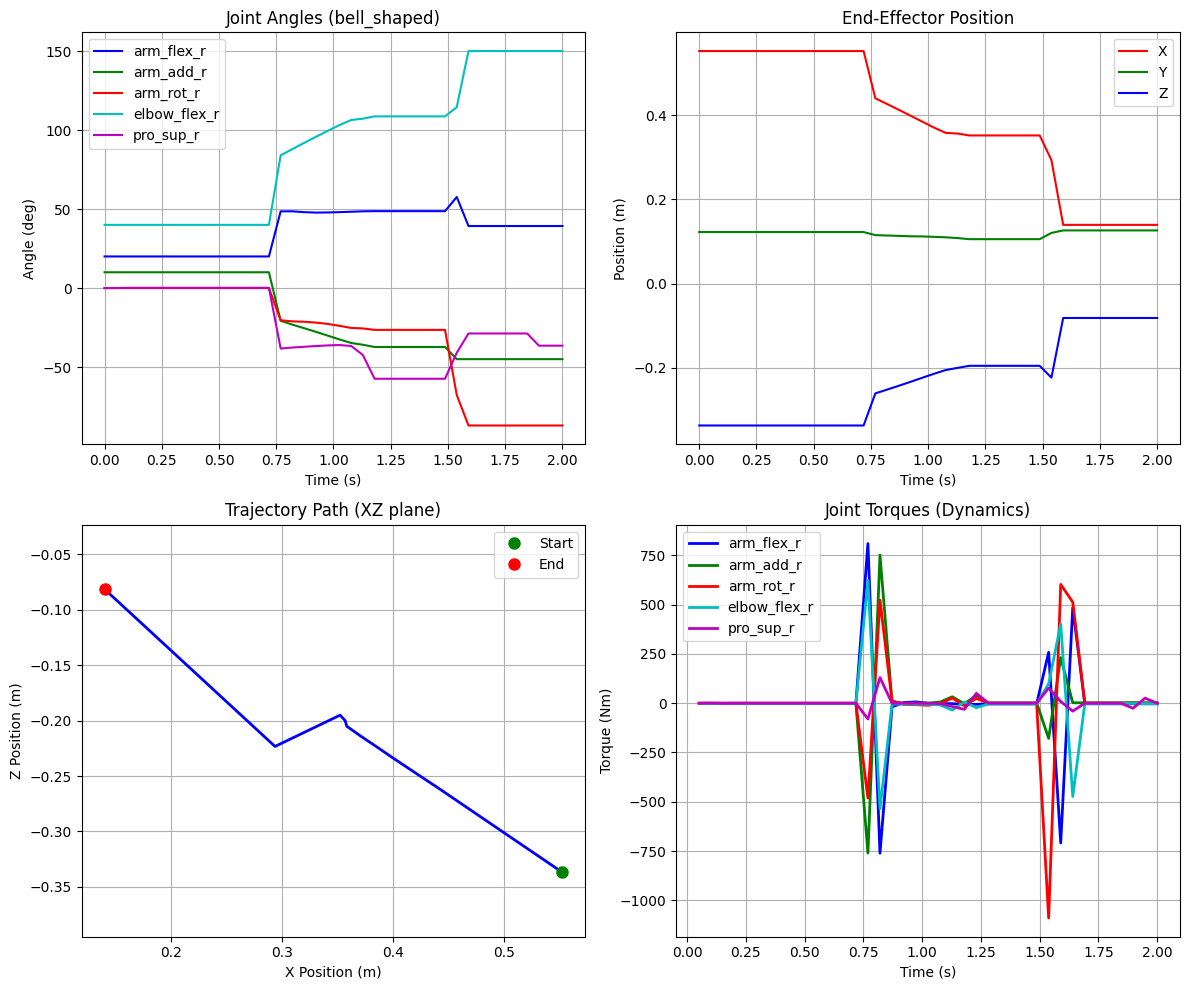


🎉 Realistic reaching movement WITH DYNAMICS generated!
The motion file now includes joint torques and energy analysis.
🎯 Target: [ 0.2  0.1 -0.1]
📏 Distance: 0.24m
Point 0: Error=0.000m, Elbow=40.0°
Point 10: Error=0.047m, Elbow=40.0°
Point 20: Error=0.002m, Elbow=103.5°
Point 30: Error=0.101m, Elbow=150.0°
✅ Motion file with dynamics created: minimum_jerk_reaching_with_dynamics.mot

📊 Final joint angles:
  arm_flex_r: 40.1°
  arm_add_r: -45.0°
  arm_rot_r: -88.4°
  elbow_flex_r: 150.0°
  pro_sup_r: -21.3°

💪 Final Joint Torques:
  arm_flex_r: -3.22 Nm
  arm_add_r: 2.12 Nm
  arm_rot_r: 0.00 Nm
  elbow_flex_r: -2.00 Nm
  pro_sup_r: 0.00 Nm
🔋 Total Mechanical Energy: 9.16 J


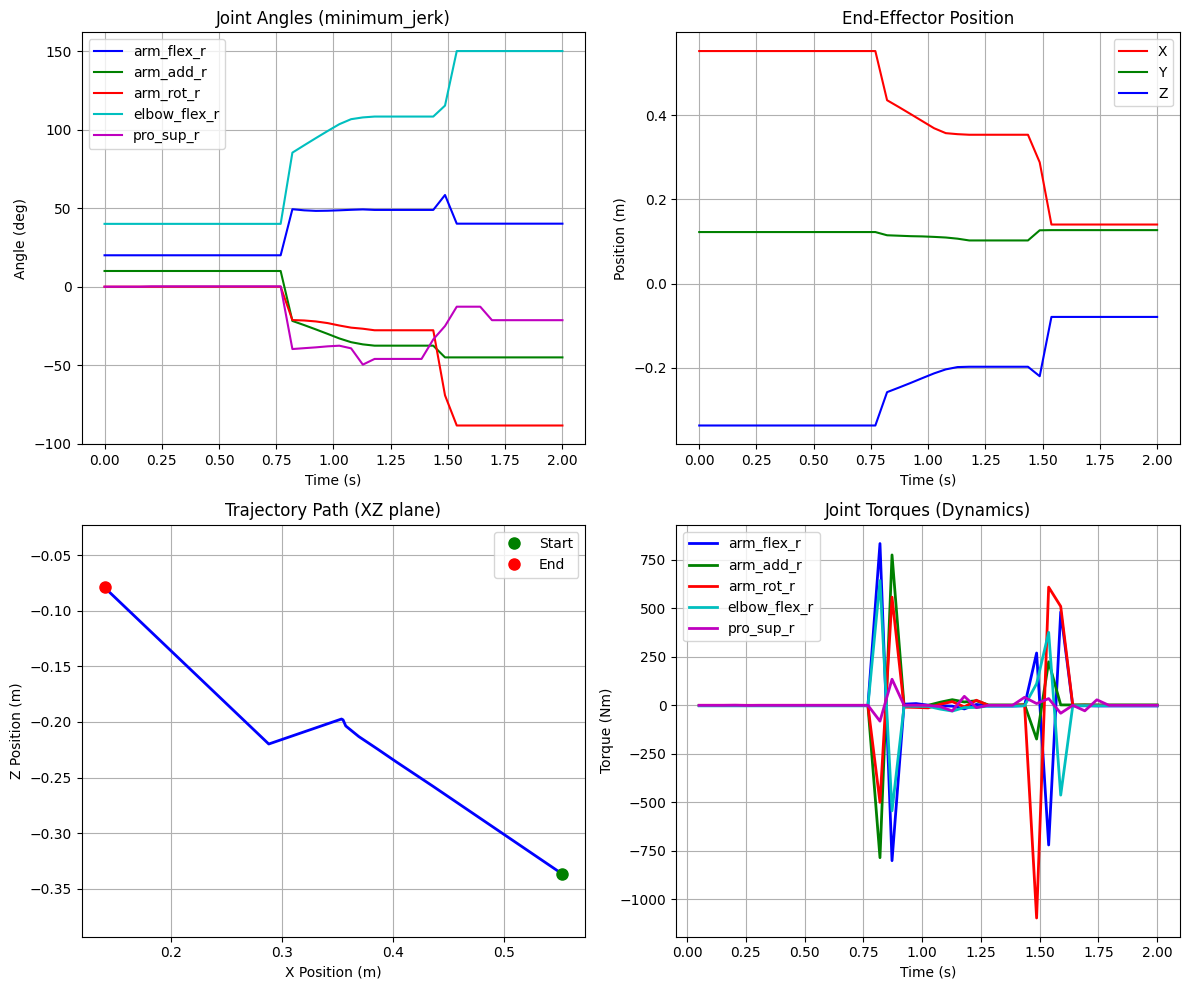


🎉 Minimum jerk reaching movement WITH DYNAMICS generated!
The motion file now includes joint torques and energy analysis.


In [55]:
def generate_realistic_reaching(model_path, output_file, trajectory_type='bell_shaped', **kwargs):
    """Generate a realistic forward-reaching movement WITH DYNAMICS."""
    # Change this line to use the dynamics-enabled system
    system = OpenSimReachingSystem3D(model_path)  # CHANGED
    
    if not system.valid_coords:
        return False
    
    # Start with arm slightly bent
    start_angles = {
        'arm_flex_r': np.radians(20),
        'arm_add_r': np.radians(10),
        'arm_rot_r': 0,
        'elbow_flex_r': np.radians(40),
        'pro_sup_r': 0
    }
    
    # Target position - forward and slightly up (natural reaching)
    target_pos = np.array([0.2, 0.1, -0.1])  # Forward, right, up
    
    print(f"🎯 Target: {target_pos}")
    print(f"📏 Distance: {np.linalg.norm(target_pos):.2f}m")
    
    # Generate movement WITH DYNAMICS - this now returns a dictionary
    movement_data = system.generate_reaching_movement(  # CHANGED
        start_angles, target_pos, duration=2.0, num_points=40, 
        trajectory_type=trajectory_type, **kwargs
    )
    
    # Extract the data from the dictionary
    time_points = movement_data['time_points']
    joint_angles_history = movement_data['joint_angles']
    positions = movement_data['positions']
    dynamics_data = movement_data['dynamics']  # NEW: Dynamics data
    
    # Create enhanced motion file WITH TORQUES
    with open(output_file, 'w') as f:
        f.write("name realistic_reaching_with_dynamics\n")  # CHANGED
        f.write("datacolumns 11\n")  # CHANGED: time + 5 positions + 5 torques
        f.write(f"datarows {len(time_points)}\n")
        f.write(f"range {time_points[0]} {time_points[-1]}\n")
        f.write("endheader\n")
        
        # CHANGED: Add torque columns
        f.write("time\t")
        f.write("\t".join([f"{name}" for name in system.joint_names]) + "\t")
        f.write("\t".join([f"{name}_tau" for name in system.joint_names]) + "\n")
        
        for i, t in enumerate(time_points):
            angles_deg = [np.degrees(joint_angles_history[i][name]) for name in system.joint_names]
            
            # NEW: Add torques to the motion file
            if i < len(dynamics_data['joint_torques']):
                # Torques are offset by 1 due to velocity calculation
                torque_idx = i - 1 if i > 0 else 0
                torques = dynamics_data['joint_torques'][torque_idx]
            else:
                torques = np.zeros(5)
            
            f.write(f"{t:.6f}\t")
            f.write("\t".join([f"{a:.6f}" for a in angles_deg]) + "\t")
            f.write("\t".join([f"{tau:.6f}" for tau in torques]) + "\n")
    
    print(f"✅ Motion file with dynamics created: {output_file}")
    
    # Show final joint angles
    final_angles = joint_angles_history[-1]
    print("\n📊 Final joint angles:")
    for joint, angle in final_angles.items():
        print(f"  {joint}: {np.degrees(angle):.1f}°")
    
    # NEW: Show dynamics summary
    if len(dynamics_data['joint_torques']) > 0:
        final_torques = dynamics_data['joint_torques'][-1]
        print("\n💪 Final Joint Torques:")
        for joint, torque in zip(system.joint_names, final_torques):
            print(f"  {joint}: {torque:.2f} Nm")
        
        total_energy = np.sum(dynamics_data['energy'][-1])
        print(f"🔋 Total Mechanical Energy: {total_energy:.2f} J")

    # Plot analysis WITH DYNAMICS
    system.plot_trajectory_analysis(movement_data, trajectory_type)  # CHANGED
    
    return True


def compare_trajectory_types(model_path):
    """Compare different trajectory generation methods WITH DYNAMICS."""
    trajectory_types = ['bell_shaped', 'minimum_jerk']  # Removed 'linear' if not in your TrajectoryGenerator
    
    for traj_type in trajectory_types:
        output_file = f"reaching_{traj_type}_with_dynamics.mot"  # CHANGED
        print(f"\n{'='*50}")
        print(f"Testing {traj_type.upper()} trajectory WITH DYNAMICS")  # CHANGED
        print(f"{'='*50}")
        
        generate_realistic_reaching(
            model_path, 
            output_file, 
            trajectory_type=traj_type,
            peak_time_ratio=0.4,  # For bell_shaped
            sigma=0.2             # For bell_shaped
        )


if __name__ == "__main__":
    model_path = "W:\Models\FullBodyModel-4.0\Rajagopal2015.osim" 
    
    # Generate with bell-shaped trajectory and dynamics
    if generate_realistic_reaching(model_path, 'bell_shaped_reaching_with_dynamics.mot', 
                                 trajectory_type='bell_shaped', peak_time_ratio=0.4, sigma=0.2):
        print("\n🎉 Realistic reaching movement WITH DYNAMICS generated!")
        print("The motion file now includes joint torques and energy analysis.")

    # Generate with minimum jerk trajectory and dynamics  
    if generate_realistic_reaching(model_path, 'minimum_jerk_reaching_with_dynamics.mot', 
                                 trajectory_type='minimum_jerk'):
        print("\n🎉 Minimum jerk reaching movement WITH DYNAMICS generated!")
        print("The motion file now includes joint torques and energy analysis.")
    
